### Introduction

In this Milestone(3), we are concerned with the efficiency of differend Neural Networks; fit_time, prediction_time, accuracy, etc. Although the structure of this MS is like the previous MS, but we have done a thorogh and comprehensive study on the performance of the models. Five models has been tested deeply; please note that if you have completely random NN, the accuracy should be around 4%. While our models can easily provide more than 50%.

#### Group members: Hamid Pour Mohammad, Mehdi Naghi Lou, Saeid Entezari.

In [1]:
import tensorflow as tf
from tensorflow import keras as ks
import numpy as np
from pandas import read_csv, concat, DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from time import time

In [2]:
from pandas import read_csv
df=read_csv('data_clean.csv') # importing the data

def sampler(df, n): # It chooses n samples from df (encoding and cleaning are considered)
    df_s=df.sample(n)
    encoder=LabelEncoder() # encoding the labels
    encoder.fit(df_s['target_tag'])
    global encoder_classes # saving the order of the classes
    encoder_classes=encoder.classes_
    df_s['target_tag']=encoder.transform(df_s['target_tag'])
    # we have a reason to delete the 164th feature! Explanation is too long; but in short, it's because of
    # the intercurrent variables. So, let's get rid of it:
    df_s= concat([df_s.iloc[:,1:164], df_s.iloc[:,165:]], axis=1)
    return df_s

# converting probabilities to classes, and make confusion matrix:
def confusion_matrix_func(model, X_test, Y_test): 
    def probability_to_class(Y_pred_probabilities):
        Y_pred=[np.argmax(i) for i in Y_pred_probabilities]
        return Y_pred

    Y_pred=probability_to_class(model.predict(X_test))
    conf_matrix=DataFrame(encoder_classes, columns=[''])
    conf_matrix=concat([conf_matrix, 
                        DataFrame(confusion_matrix(Y_test, Y_pred), columns=list(encoder_classes))], axis=1)
    return conf_matrix

### Evaluating the models:


As the metrics, we want to use confusion matrix first. Because it shows us how many predictions are correct, without considering the importance of each class; no class is superior in our research. On the other hand, some of wrong predictions are important. because some of them show the better choice to classify a Tweet; and some of them show the correlations and overlapping of different classes. For example, 'gym' and 'bodybuilding' are overlapping according to the confusion matrix, and you can find correlations and overlapping very well. Also, almost all the classes have the same number of samples, so we consider the accuracy of prediction, as another metric. Please note that our metric is sparse_categorical_accuracy, because we have 27 classes. Neural network models can find the correlations between various words in the texture of tweets; so they can provide accurate predictions if they have been trained well.



### Changing the complexity:

In the below link:
https://www.innoarchitech.com/blog/machine-learning-an-in-depth-non-technical-guide-part-3
you can read:

"In machine learning, model complexity often refers to the number of features or terms included in
a given predictive model, as well as whether the chosen model is linear, nonlinear, and so on. It can
also refer to the algorithmic learning complexity or computational complexity."

Thus, we will change the number of features (kept features) in each model, and explore optimal value. Also, we change the structure of the model (it means the comlexity of the structure of the model will change too).

In [5]:
# These lists will be utlized for comparing the models:
fit_time_list=[]
predict_time_list=[]
best_accuracy_list=[]
best_val_accuracy_list=[]
min_loss_list=[]
min_val_loss_list=[]
bias_list=[]
variance_list=[]

===================================================================================================================

### Model 1:
In this model, we are utlizing a NN with two hidden layers; 400 nodes for each hidden layer. The activation function is relu (it's sigmoid for output layer). The optimizing algorithm is SGD with lr=0.1. Also, we have considered regularization to have 0.01 impact coefficient. About loss function and metric, they are sparse_categorical_crossentropy and sparse_categorical_accuracy.

Validation Curve process for model_1:
(Please note that our metric is acuuracy: sparse_categorical_accuracy)
200 features: done
440 features: done
680 features: done
920 features: done
1160 features: done
1400 features: done
1640 features: done
1784 features: done

The optimal value for the Complexity (n_f) is: 1400


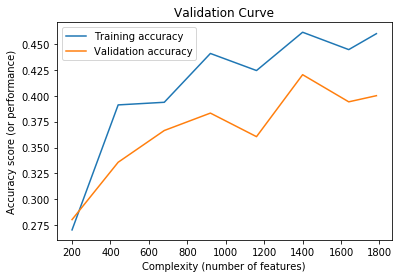

In [6]:
# model_1:
# Let's train some different forms of model_1:
# different number of features; changing the complexity:
n_kept_features = list(range(200, df.shape[1]+1, 240)) + [df.shape[1]-3]  
accuracy_list=[]
val_accuracy_list=[]

print('Validation Curve process for model_1:')
print('(Please note that our metric is acuuracy: sparse_categorical_accuracy)')
start_time=time() # time for fitting
for n in n_kept_features:
    acc=[] # calculate the accuracy for a few times
    val_acc=[] # calculate the validation accuracy for a few times
    for i in range(3): # training a few times, to find the average
        df_sample=sampler(df, 3000) # choose some samples
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n], df_sample['target_tag'])
    
        reg_coef_1=0.01 # impact coefficient of regularization
        model_1=ks.models.Sequential()
        model_1.add(ks.layers.Dense(units=400, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_1)))
        model_1.add(ks.layers.Dense(units=400, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_1)))
        model_1.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))
    
        model_1.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_1.fit(X_train, Y_train, validation_split=0.1, epochs=7, batch_size=30, verbose=0)
        acc.append( np.mean( np.sort(history.history['sparse_categorical_accuracy'])[-3:] ) )
        val_acc.append( np.mean( np.sort(history.history['val_sparse_categorical_accuracy'])[-3:] ) )
        
    accuracy_list.append(np.mean(acc))
    val_accuracy_list.append(np.mean( val_acc ))
    print(f'{n} features: done')
    
end_time=time()
    
print(f'\nThe optimal value for the Complexity (n_f) is: {n_kept_features[np.argmax(val_accuracy_list)]}')
plt.plot(n_kept_features, accuracy_list, label='Training accuracy')
plt.plot(n_kept_features, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Complexity (number of features)'), plt.ylabel('Accuracy score (or performance)')
plt.title('Validation Curve')
plt.legend()

In [7]:
# model_1:
# average fitting time (for various n_kept_features):
fit_time_list.append( (end_time-start_time)/len(n_kept_features) ) 
best_accuracy_list.append(max(accuracy_list))
best_val_accuracy_list.append(max(val_accuracy_list))

print('Confusion Matrix for model_1:')
# Please note that there are 27 classes; so it's quiet fair to have a large confusion matrix
start_time=time()
c_m=confusion_matrix_func(model_1, X_test, Y_test)
end_time=time()
predict_time_list.append(end_time-start_time)

c_m

Confusion Matrix for model_1:


,,animal,architecture,art,biology,bodybuilding,business,covid,culture,election,...,marketing,medical,pet,pharmacy,physics,political,science,solar,technology,travel
0,animal,20,0,2,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,7,0
1,architecture,0,6,0,0,0,0,0,0,0,...,6,0,0,0,0,0,0,0,14,0
2,art,1,0,16,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,8,0
3,biology,0,0,0,7,0,0,0,0,0,...,0,0,0,0,19,0,0,0,2,0
4,bodybuilding,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
5,business,0,0,0,1,0,0,3,0,0,...,14,0,0,0,5,0,0,0,9,0
6,covid,0,0,0,0,0,0,12,0,0,...,3,0,0,0,0,0,0,0,11,0
7,culture,0,0,0,0,0,0,1,16,0,...,5,0,0,0,0,0,0,0,13,0
8,election,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,0
9,engineering,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,19,0


Learning Curve process for model_1:
700 samples: done
1200 samples: done
1700 samples: done
2200 samples: done
2700 samples: done
3000 samples: done

Bias: 2.575176378091176
Variance: 0.20309215784072887
According to the amount of bias and variance, it seems that we have enough data. Please 
note that we have 100,000 samples (in total). And it is almost a good model.


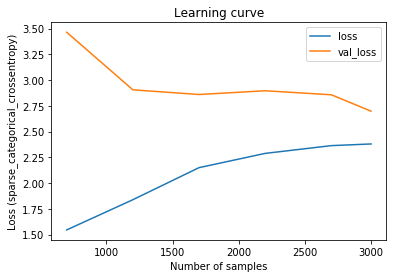

In [8]:
# model_1:
# Now, we are exploring the Learning Curve process:
n_f=600 # let's set the number of features to be 600 for here (we are still in model_1):
n_samples=[700, 1200, 1700, 2200, 2700, 3000] # number of data samples we are using here
loss_list=[]
val_loss_list=[]

print('Learning Curve process for model_1:')
for n_s in n_samples:
    loss=[]
    val_loss=[]
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, n_s)
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n_f], df_sample['target_tag'])
        
        reg_coef_1=0.01
        model_1=ks.models.Sequential()
        model_1.add(ks.layers.Dense(units=400, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_1)))
        model_1.add(ks.layers.Dense(units=400, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_1)))
        model_1.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))
    
        model_1.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_1.fit(X_train, Y_train, validation_split=0.1, epochs=17, batch_size=5, verbose=0)
        loss.append( np.mean( np.sort(history.history['loss'])[:3] ) )
        val_loss.append( np.mean( np.sort(history.history['val_loss'])[:3] ) )

    loss_list.append(np.mean( loss ))
    val_loss_list.append(np.mean( val_loss ))
    print(f'{n_s} samples: done')
    
min_loss_list.append(min(loss_list))
min_val_loss_list.append(min(val_loss_list))
    
print(f'\nBias: {np.mean(loss_list[-2:]+val_loss_list[-2:])}')
print(f'Variance: {np.mean(np.array(val_loss_list[-2:])-np.array(loss_list[-2:]))/2}')
print("""According to the amount of bias and variance, it seems that we have enough data. Please 
note that we have 100,000 samples (in total). And it is almost a good model.""")
plt.plot(n_samples, loss_list, label='loss')
plt.plot(n_samples, val_loss_list, label='val_loss')
plt.xlabel('Number of samples'), plt.ylabel('Loss (sparse_categorical_crossentropy)')
plt.title('Learning curve')
plt.legend()

Please note that we are using regularization with 0.01 impact coefficient. Without regularization, we have to deal with overfitting.

In [9]:
bias_list.append( np.mean(loss_list[-2:]+val_loss_list[-2:]) )
variance_list.append( np.mean(np.array(val_loss_list[-2:])-np.array(loss_list[-2:]))/2 )

### Fine tunning other hyper-parameter of the model:
Now, we like to fine tune other hyper-parameter of the model; it's batch_size. Because we have understood that it is very important to have a good batch_size.

Fine tunning another hyper-parameter of model_1:
Batch_size = 1 : done
Batch_size = 3 : done
Batch_size = 5 : done
Batch_size = 8 : done
Batch_size = 12 : done
Batch_size = 15 : done

Best Batch_size: 3


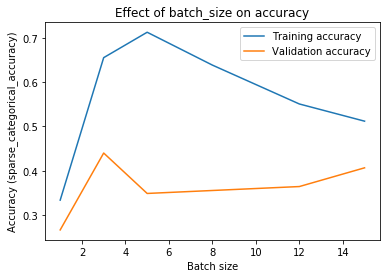

In [16]:
# model_1:
# Fine tunning another hyper-model of model_1; batch_size or learning rate can be tunned. 
# Here, we go for the batch_size:
n_f=600 
n_batch_sizes=[1, 3, 5, 8, 12, 15] # different number of batch_size
accuracy_list=[]
val_accuracy_list=[]

print('Fine tunning another hyper-parameter of model_1:')
for n_b_s in n_batch_sizes:
    accuracy=[]
    val_accuracy=[]
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, 1000) 
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n_f], df_sample['target_tag'])
        
        reg_coef_1=0.01
        model_1=ks.models.Sequential()
        model_1.add(ks.layers.Dense(units=400, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_1)))
        model_1.add(ks.layers.Dense(units=400, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_1)))
        model_1.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))
    
        model_1.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_1.fit(X_train, Y_train, validation_split=0.1, epochs=10, batch_size=n_b_s, verbose=0)
        accuracy.append( np.mean( np.sort(history.history['sparse_categorical_accuracy'])[-3:] ) )
        val_accuracy.append( np.mean( np.sort(history.history['val_sparse_categorical_accuracy'])[-3:] ) )

    accuracy_list.append(np.mean( accuracy ))
    val_accuracy_list.append(np.mean( val_accuracy ))
    print(f'Batch_size = {n_b_s} : done')
    
print(f'\nBest Batch_size: {n_batch_sizes[ np.argmax(val_accuracy_list) ]}')
plt.plot(n_batch_sizes, accuracy_list, label='Training accuracy')
plt.plot(n_batch_sizes, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Batch size'), plt.ylabel('Accuracy (sparse_categorical_accuracy)')
plt.title('Effect of batch_size on accuracy')
plt.legend()

===================================================================================================================

### Model 2:
In the second model, we are utlizing a NN with 3 hidden layers; 350, 400, 100 nodes for hidden layers. Actually, we are making the NN deeper. The activation function is relu (it's sigmoid for output layer). The optimizing algorithm is SGD with lr=0.1 and batch_size=5. Also, we have considered regularization to have 0.01 impact coefficient. About loss function and metric, they are sparse_categorical_crossentropy and sparse_categorical_accuracy.

Validation Curve process for model_2:
(Please note that our metric is acuuracy: sparse_categorical_accuracy)
300 features: done
600 features: done
900 features: done
1200 features: done
1500 features: done
1784 features: done

The optimal value for the Complexity (n_f) is: 1784


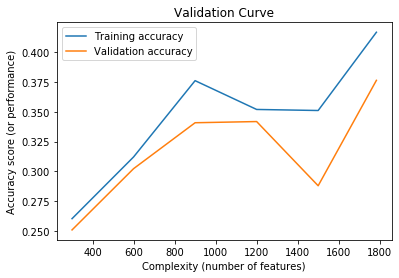

In [17]:
# model_2:
# Let's train some different forms of model_2:
# different number of features; changing the complexity:
n_kept_features = list(range(300, df.shape[1]+1, 300)) + [df.shape[1]-3]
accuracy_list=[]
val_accuracy_list=[]

print('Validation Curve process for model_2:')
print('(Please note that our metric is acuuracy: sparse_categorical_accuracy)')
start_time=time() # time for fitting
for n in n_kept_features:
    acc=[] # calculate the accuracy for a few times
    val_acc=[] # calculate the validation accuracy for a few times
    for i in range(3): # training a few times, to find the average
        df_sample=sampler(df, 3000) # choose some samples
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n], df_sample['target_tag'])
    
        reg_coef_2=0.01 # impact coefficient of regularization
        model_2=ks.models.Sequential()
        model_2.add(ks.layers.Dense(units=350, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_2)))
        model_2.add(ks.layers.Dense(units=400, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_2)))
        model_2.add(ks.layers.Dense(units=100, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_2)))
        model_2.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))
    
        model_2.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_2.fit(X_train, Y_train, validation_split=0.1, epochs=7, batch_size=5, verbose=0)
        acc.append( np.mean( np.sort(history.history['sparse_categorical_accuracy'])[-3:] ) )
        val_acc.append( np.mean( np.sort(history.history['val_sparse_categorical_accuracy'])[-3:] ) )
        
    accuracy_list.append(np.mean(acc))
    val_accuracy_list.append(np.mean( val_acc ))
    print(f'{n} features: done')
    
end_time=time()
    
print(f'\nThe optimal value for the Complexity (n_f) is: {n_kept_features[np.argmax(val_accuracy_list)]}')
plt.plot(n_kept_features, accuracy_list, label='Training accuracy')
plt.plot(n_kept_features, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Complexity (number of features)'), plt.ylabel('Accuracy score (or performance)')
plt.title('Validation Curve')
plt.legend()

In [18]:
# model_2:
# average fitting time (for various n_kept_features):
fit_time_list.append( (end_time-start_time)/len(n_kept_features) ) 
best_accuracy_list.append(max(accuracy_list))
best_val_accuracy_list.append(max(val_accuracy_list))

print('Confusion Matrix for model_2:')
# Please note that there are 27 classes; so it's quiet fair to have a large confusion matrix
start_time=time()
c_m=confusion_matrix_func(model_2, X_test, Y_test)
end_time=time()
predict_time_list.append(end_time-start_time)

c_m

Confusion Matrix for model_2:


,,animal,architecture,art,biology,bodybuilding,business,covid,culture,election,...,marketing,medical,pet,pharmacy,physics,political,science,solar,technology,travel
0,animal,7,0,3,0,0,0,1,0,0,...,1,1,3,0,0,0,0,0,1,3
1,architecture,0,17,2,0,0,0,0,1,0,...,0,2,0,0,0,0,2,0,1,5
2,art,2,0,22,0,0,3,0,1,0,...,3,2,0,0,0,0,0,0,2,0
3,biology,0,0,0,18,0,0,0,0,0,...,0,0,0,0,7,0,1,0,0,0
4,bodybuilding,0,0,1,0,0,0,0,0,0,...,2,1,0,0,0,0,0,0,0,0
5,business,0,1,0,3,0,5,0,1,0,...,10,5,0,0,1,0,5,0,3,2
6,covid,1,0,0,0,0,0,10,1,0,...,2,6,0,0,0,0,2,0,2,1
7,culture,0,1,1,0,0,1,0,8,0,...,4,3,0,0,0,0,0,0,2,2
8,election,0,0,0,0,0,2,0,1,0,...,2,0,0,0,0,0,1,0,1,1
9,engineering,0,2,0,0,0,0,0,0,0,...,2,2,0,0,1,0,5,0,4,0


Learning Curve process for model_2:
700 samples: done
1200 samples: done
1700 samples: done
2200 samples: done
2700 samples: done

Bias: 2.830942004919052
Variance: 0.15106539924939455
According to the amount of bias and variance, it seems that we have enough data. Please 
note that we have 100,000 samples (in total). And it is almost a good model.


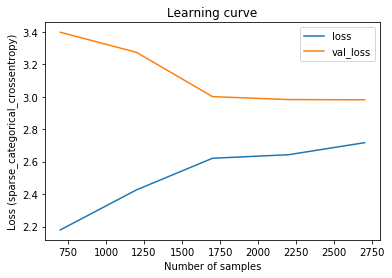

In [19]:
# model_2:
# Now, we are exploring the Learning Curve process:
n_f=600 # let's set the number of features to be 600 for here (we are still in model_2):
n_samples=[700, 1200, 1700, 2200, 2700] # number of data samples we are using here
loss_list=[]
val_loss_list=[]

print('Learning Curve process for model_2:')
for n_s in n_samples:
    loss=[]
    val_loss=[]
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, n_s)
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n_f], df_sample['target_tag'])
        
        reg_coef_2=0.01
        model_2=ks.models.Sequential()
        model_2.add(ks.layers.Dense(units=350, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_2)))
        model_2.add(ks.layers.Dense(units=400, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_2)))
        model_2.add(ks.layers.Dense(units=100, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_2)))
        model_2.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))
    
        model_2.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_2.fit(X_train, Y_train, validation_split=0.1, epochs=15, batch_size=5, verbose=0)
        loss.append( np.mean( np.sort(history.history['loss'])[:3] ) )
        val_loss.append( np.mean( np.sort(history.history['val_loss'])[:3] ) )

    loss_list.append(np.mean( loss ))
    val_loss_list.append(np.mean( val_loss ))
    print(f'{n_s} samples: done')
    
min_loss_list.append(min(loss_list))
min_val_loss_list.append(min(val_loss_list))
    
print(f'\nBias: {np.mean(loss_list[-2:]+val_loss_list[-2:])}')
print(f'Variance: {np.mean(np.array(val_loss_list[-2:])-np.array(loss_list[-2:]))/2}')
print("""According to the amount of bias and variance, it seems that we have enough data. Please 
note that we have 100,000 samples (in total). And it is almost a good model.""")
plt.plot(n_samples, loss_list, label='loss')
plt.plot(n_samples, val_loss_list, label='val_loss')
plt.xlabel('Number of samples'), plt.ylabel('Loss (sparse_categorical_crossentropy)')
plt.title('Learning curve')
plt.legend()

Please note that we are using regularization with 0.01 impact coefficient. Without regularization, we have to deal with overfitting.

In [20]:
bias_list.append( np.mean(loss_list[-2:]+val_loss_list[-2:]) )
variance_list.append( np.mean(np.array(val_loss_list[-2:])-np.array(loss_list[-2:]))/2 )

Fine tunning another hyper-parameter of model_2:
Batch_size = 2 : done
Batch_size = 5 : done
Batch_size = 8 : done
Batch_size = 12 : done
Batch_size = 15 : done

Best Batch_size: 8


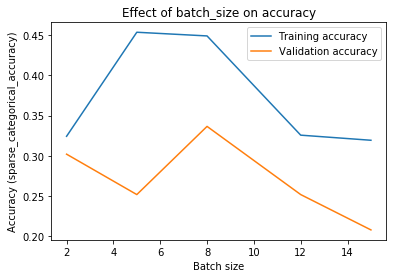

In [21]:
# model_2:
# Fine tunning another hyper-model of model_2; batch_size or learning rate can be tunned. 
# Here, we go for the batch_size:
n_f=600 
n_batch_sizes=[2, 5, 8, 12, 15] # different number of batch_size
accuracy_list=[]
val_accuracy_list=[]

print('Fine tunning another hyper-parameter of model_2:')
for n_b_s in n_batch_sizes:
    accuracy=[]
    val_accuracy=[]
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, 700)
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n_f], df_sample['target_tag'])
        
        reg_coef_2=0.01
        model_2=ks.models.Sequential()
        model_2.add(ks.layers.Dense(units=350, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_2)))
        model_2.add(ks.layers.Dense(units=400, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_2)))
        model_2.add(ks.layers.Dense(units=100, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_2)))
        model_2.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))
    
        model_2.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_2.fit(X_train, Y_train, validation_split=0.1, epochs=10, batch_size=n_b_s, verbose=0)
        accuracy.append( np.mean( np.sort(history.history['sparse_categorical_accuracy'])[-3:] ) )
        val_accuracy.append( np.mean( np.sort(history.history['val_sparse_categorical_accuracy'])[-3:] ) )

    accuracy_list.append(np.mean( accuracy ))
    val_accuracy_list.append(np.mean( val_accuracy ))
    print(f'Batch_size = {n_b_s} : done')
    
print(f'\nBest Batch_size: {n_batch_sizes[ np.argmax(val_accuracy_list) ]}')
plt.plot(n_batch_sizes, accuracy_list, label='Training accuracy')
plt.plot(n_batch_sizes, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Batch size'), plt.ylabel('Accuracy (sparse_categorical_accuracy)')
plt.title('Effect of batch_size on accuracy')
plt.legend()

===================================================================================================================

### Model 3:
In the third model, we are utlizing a NN with 2 hidden layers; 350 and 350 nodes for hidden layers. The activation function is still relu (it's sigmoid for output layer). But now, the optimizing algorithm is ADAM with batch_size=10, and starting learning_rate=0.005. Also, we have considered Dropout layers after each layers of nodes, with 0.8 probability. About loss function and metric, they are sparse_categorical_crossentropy and sparse_categorical_accuracy.

Validation Curve process for model_3:
(Please note that our metric is acuuracy: sparse_categorical_accuracy)
200 features: done
500 features: done
1000 features: done
1500 features: done
1784 features: done

The optimal value for the Complexity (n_f) is: 1000


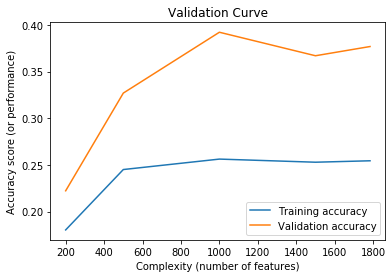

In [30]:
# model_3:
# Let's train some different forms of model_3:
# different number of features; changing the complexity:
n_kept_features=[200, 500, 1000, 1500, df.shape[1]-3]
accuracy_list=[]
val_accuracy_list=[]

print('Validation Curve process for model_3:')
print('(Please note that our metric is acuuracy: sparse_categorical_accuracy)')
start_time=time() # time for fitting
for n in n_kept_features:
    acc=[] # calculate the accuracy for a few times
    val_acc=[] # calculate the validation accuracy for a few times
    for i in range(3): # training a few times, to find the average
        df_sample=sampler(df, 3000) # choose some samples
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n], df_sample['target_tag'])

        model_3=ks.models.Sequential()
        model_3.add(ks.layers.Dense(units=350, activation=ks.activations.relu, input_dim=X_train.shape[1]))
        model_3.add(ks.layers.Dropout(0.8))
        model_3.add(ks.layers.Dense(units=350, activation=ks.activations.relu))
        model_3.add(ks.layers.Dropout(0.8))
        model_3.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))

        model_3.compile(optimizer=ks.optimizers.Adam(0.005), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_3.fit(X_train, Y_train, validation_split=0.1, epochs=7, batch_size=10, verbose=0)
        
        acc.append( np.mean( np.sort(history.history['sparse_categorical_accuracy'])[-3:] ) )
        val_acc.append( np.mean( np.sort(history.history['val_sparse_categorical_accuracy'])[-3:] ) )
        
    accuracy_list.append(np.mean(acc))
    val_accuracy_list.append(np.mean( val_acc ))
    print(f'{n} features: done')
    
end_time=time()
    
print(f'\nThe optimal value for the Complexity (n_f) is: {n_kept_features[np.argmax(val_accuracy_list)]}')
plt.plot(n_kept_features, accuracy_list, label='Training accuracy')
plt.plot(n_kept_features, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Complexity (number of features)'), plt.ylabel('Accuracy score (or performance)')
plt.title('Validation Curve')
plt.legend()

Plese note that we are utlizing Dropout; this is why Validation accuracy is greater than Training accuracy.

In [31]:
# model_3:
# average fitting time (for various n_kept_features):
fit_time_list.append( (end_time-start_time)/len(n_kept_features) ) 
best_accuracy_list.append(max(accuracy_list))
best_val_accuracy_list.append(max(val_accuracy_list))

print('Confusion Matrix for model_3:')
# Please note that there are 27 classes; so it's quiet fair to have a large confusion matrix
start_time=time()
c_m=confusion_matrix_func(model_3, X_test, Y_test)
end_time=time()
predict_time_list.append(end_time-start_time)

c_m

Confusion Matrix for model_3:


,,animal,architecture,art,biology,bodybuilding,business,covid,culture,election,...,marketing,medical,pet,pharmacy,physics,political,science,solar,technology,travel
0,animal,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,architecture,0,16,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,4
2,art,0,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,biology,0,0,0,22,0,0,0,0,0,...,2,0,0,0,1,0,1,0,0,0
4,bodybuilding,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,2,0,2,5
5,business,0,0,0,3,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,1
6,covid,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
7,culture,0,0,0,0,0,0,0,6,0,...,0,0,0,0,0,0,1,0,0,2
8,election,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,engineering,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,5


Learning Curve process for model_3:
700 samples: done
1200 samples: done
1700 samples: done
2200 samples: done
2700 samples: done

Bias: 2.7787423829237623
Variance: -0.16706370313962293
According to the bias and variance, it is not obvious if the data is enough or not, for this
model. It seems tha the model is not performing well (maybe, Dropout is not suitable for this model.)


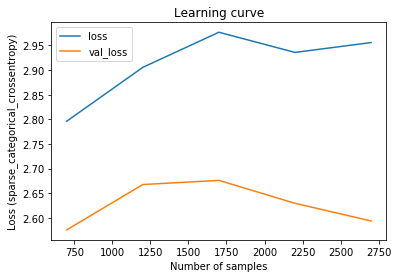

In [32]:
# model_3:
# Now, we are exploring the Learning Curve process:
n_f=600 # let's set the number of features to be 600 for here (we are still in model_3):
n_samples=[700, 1200, 1700, 2200, 2700] # number of data samples we are using here
loss_list=[]
val_loss_list=[]

print('Learning Curve process for model_3:')
for n_s in n_samples:
    loss=[]
    val_loss=[]
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, n_s)
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n_f], df_sample['target_tag'])
        
        model_3=ks.models.Sequential()
        model_3.add(ks.layers.Dense(units=350, activation=ks.activations.relu, input_dim=X_train.shape[1]))
        model_3.add(ks.layers.Dropout(0.8))
        model_3.add(ks.layers.Dense(units=350, activation=ks.activations.relu))
        model_3.add(ks.layers.Dropout(0.8))
        model_3.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))

        model_3.compile(optimizer=ks.optimizers.Adam(0.005), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_3.fit(X_train, Y_train, validation_split=0.1, epochs=10, batch_size=10, verbose=0)
        loss.append( np.mean( np.sort(history.history['loss'])[:3] ) )
        val_loss.append( np.mean( np.sort(history.history['val_loss'])[:3] ) )

    loss_list.append(np.mean( loss ))
    val_loss_list.append(np.mean( val_loss ))
    print(f'{n_s} samples: done')
    
min_loss_list.append(min(loss_list))
min_val_loss_list.append(min(val_loss_list))
    
print(f'\nBias: {np.mean(loss_list[-2:]+val_loss_list[-2:])}')
print(f'Variance: {np.mean(np.array(val_loss_list[-2:])-np.array(loss_list[-2:]))/2}')
print("""According to the bias and variance, it is not obvious if the data is enough or not, for this
model. It seems tha the model is not performing well (maybe, Dropout is not suitable for this model.)""")
plt.plot(n_samples, loss_list, label='loss')
plt.plot(n_samples, val_loss_list, label='val_loss')
plt.xlabel('Number of samples'), plt.ylabel('Loss (sparse_categorical_crossentropy)')
plt.title('Learning curve')
plt.legend()

As we know, since we are using Dropout, the Training Loss is not comprehensive. Also, the learning curve does not seems to be very helpful.

On the other hand, we shoud note that we have 100,000 samples (in total). Anyway we are not sure model_3 can be useful for these data.')

In [33]:
bias_list.append( np.mean(loss_list[-2:]+val_loss_list[-2:]) )
variance_list.append( np.mean(np.array(val_loss_list[-2:])-np.array(loss_list[-2:]))/2 )

Fine tunning another hyper-parameter of model_3:
Batch_size = 2 : done
Batch_size = 5 : done
Batch_size = 8 : done
Batch_size = 12 : done
Batch_size = 15 : done

Best Batch_size: 12


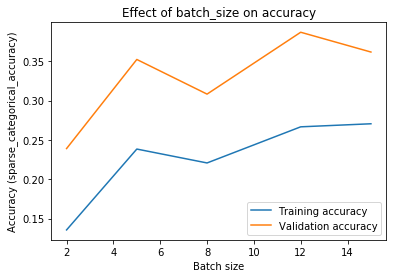

In [34]:
# model_3:
# Fine tunning another hyper-model of model_3; batch_size or the probability of the Dropout can be tunned. 
# Here, we go for the batch_size:
n_f=600 
n_batch_sizes=[2, 5, 8, 12, 15] # different number of batch_size
accuracy_list=[]
val_accuracy_list=[]

print('Fine tunning another hyper-parameter of model_3:')
for n_b_s in n_batch_sizes:
    accuracy=[]
    val_accuracy=[]
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, 700)
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n_f], df_sample['target_tag'])
        
        model_3=ks.models.Sequential()
        model_3.add(ks.layers.Dense(units=350, activation=ks.activations.relu, input_dim=X_train.shape[1]))
        model_3.add(ks.layers.Dropout(0.8))
        model_3.add(ks.layers.Dense(units=350, activation=ks.activations.relu))
        model_3.add(ks.layers.Dropout(0.8))
        model_3.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))

        model_3.compile(optimizer=ks.optimizers.Adam(0.005), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_3.fit(X_train, Y_train, validation_split=0.1, epochs=8, batch_size=n_b_s, verbose=0)
        accuracy.append( np.mean( np.sort(history.history['sparse_categorical_accuracy'])[-3:] ) )
        val_accuracy.append( np.mean( np.sort(history.history['val_sparse_categorical_accuracy'])[-3:] ) )

    accuracy_list.append(np.mean( accuracy ))
    val_accuracy_list.append(np.mean( val_accuracy ))
    print(f'Batch_size = {n_b_s} : done')
    
print(f'\nBest Batch_size: {n_batch_sizes[ np.argmax(val_accuracy_list) ]}')
plt.plot(n_batch_sizes, accuracy_list, label='Training accuracy')
plt.plot(n_batch_sizes, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Batch size'), plt.ylabel('Accuracy (sparse_categorical_accuracy)')
plt.title('Effect of batch_size on accuracy')
plt.legend()

===================================================================================================================

### Model 4:
In the forth model, we are utlizing a NN with 4 hidden layers; 400, 300, 150, 150 nodes for hidden layers. Actually, we are making the NN deeper. The activation function is relu (it's sigmoid for output layer). The optimizing algorithm is SGD with lr=0.1 and batch_size=5. Also, we have considered regularization to have 0.01 impact coefficient. About loss function and metric, they are sparse_categorical_crossentropy and sparse_categorical_accuracy.

Validation Curve process for model_4:
(Please note that our metric is acuuracy: sparse_categorical_accuracy)
200 features: done
500 features: done
1000 features: done
1500 features: done
1784 features: done

The optimal value for the Complexity (n_f) is: 1500


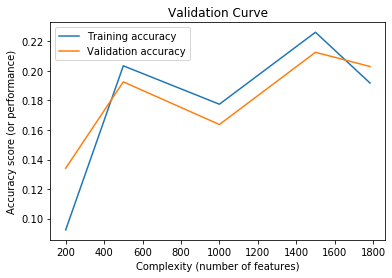

In [35]:
# model_4:
# Let's train some different forms of model_4:
# different number of features; changing the complexity:
n_kept_features=[200, 500, 1000, 1500, df.shape[1]-3]
accuracy_list=[]
val_accuracy_list=[]

print('Validation Curve process for model_4:')
print('(Please note that our metric is acuuracy: sparse_categorical_accuracy)')
start_time=time() # time for fitting
for n in n_kept_features:
    acc=[] # calculate the accuracy for a few times
    val_acc=[] # calculate the validation accuracy for a few times
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, 3000) # choose some samples
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n], df_sample['target_tag'])
    
        reg_coef_4=0.01 # impact coefficient of regularization
        model_4=ks.models.Sequential()
        model_4.add(ks.layers.Dense(units=400, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=300, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=150, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=150, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))
        
        model_4.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_4.fit(X_train, Y_train, validation_split=0.1, epochs=7, batch_size=5, verbose=0)
        acc.append( np.mean( np.sort(history.history['sparse_categorical_accuracy'])[-3:] ) )
        val_acc.append( np.mean( np.sort(history.history['val_sparse_categorical_accuracy'])[-3:] ) )
        
    accuracy_list.append(np.mean(acc))
    val_accuracy_list.append(np.mean( val_acc ))
    print(f'{n} features: done')
    
end_time=time()
    
print(f'\nThe optimal value for the Complexity (n_f) is: {n_kept_features[np.argmax(val_accuracy_list)]}')
plt.plot(n_kept_features, accuracy_list, label='Training accuracy')
plt.plot(n_kept_features, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Complexity (number of features)'), plt.ylabel('Accuracy score (or performance)')
plt.title('Validation Curve')
plt.legend()

In [36]:
# model_4:
# average fitting time (for various n_kept_features):
fit_time_list.append( (end_time-start_time)/len(n_kept_features) ) 
best_accuracy_list.append(max(accuracy_list))
best_val_accuracy_list.append(max(val_accuracy_list))

print('Confusion Matrix for model_4:')
# Please note that there are 27 classes; so it's quiet fair to have a large confusion matrix
start_time=time()
c_m=confusion_matrix_func(model_4, X_test, Y_test)
end_time=time()
predict_time_list.append(end_time-start_time)

c_m

Confusion Matrix for model_4:


,,animal,architecture,art,biology,bodybuilding,business,covid,culture,election,...,marketing,medical,pet,pharmacy,physics,political,science,solar,technology,travel
0,animal,0,0,0,0,0,6,13,0,0,...,0,0,0,0,0,0,1,0,0,7
1,architecture,0,0,0,0,0,4,10,0,0,...,0,0,0,0,0,0,1,0,0,7
2,art,0,0,0,0,0,9,15,0,0,...,0,0,0,0,0,0,3,0,0,1
3,biology,0,0,0,0,0,2,2,0,0,...,0,0,0,0,16,0,8,0,0,0
4,bodybuilding,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,8
5,business,0,0,0,0,0,3,8,0,0,...,0,0,0,0,1,0,12,0,0,0
6,covid,0,0,0,0,0,7,20,0,0,...,0,0,0,0,0,0,1,0,0,3
7,culture,0,0,0,0,0,7,21,0,0,...,0,0,0,0,0,0,2,0,0,2
8,election,0,0,0,0,0,1,9,0,0,...,0,0,0,0,0,0,1,0,0,2
9,engineering,0,0,0,0,0,3,12,0,0,...,0,0,0,0,0,0,4,0,0,7


Learning Curve process for model_4:
700 samples: done
1200 samples: done
1700 samples: done
2200 samples: done
2700 samples: done

Bias: 2.9437675972779593
Variance: 0.08559971054395055
According to the amount of bias and variance, it seems that we have enough data. Please 
note that we have 100,000 samples (in total). And it is almost a good model.


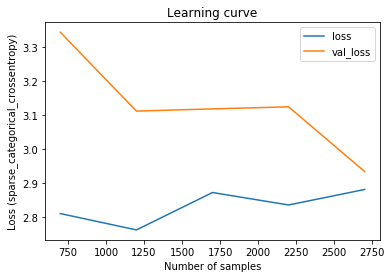

In [37]:
# model_4:
# Now, we are exploring the Learning Curve process:
n_f=600 # let's set the number of features to be 600 for here (we are still in model_4):
n_samples=[700, 1200, 1700, 2200, 2700] # number of data samples we are using here
loss_list=[]
val_loss_list=[]

print('Learning Curve process for model_4:')
for n_s in n_samples:
    loss=[]
    val_loss=[]
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, n_s)
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n_f], df_sample['target_tag'])
        
        reg_coef_4=0.01 # impact coefficient of regularization
        model_4=ks.models.Sequential()
        model_4.add(ks.layers.Dense(units=400, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=300, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=150, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=150, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))

        model_4.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_4.fit(X_train, Y_train, validation_split=0.1, epochs=15, batch_size=5, verbose=0)
        loss.append( np.mean( np.sort(history.history['loss'])[:3] ) )
        val_loss.append( np.mean( np.sort(history.history['val_loss'])[:3] ) )

    loss_list.append(np.mean( loss ))
    val_loss_list.append(np.mean( val_loss ))
    print(f'{n_s} samples: done')
    
min_loss_list.append(min(loss_list))
min_val_loss_list.append(min(val_loss_list))
    
print(f'\nBias: {np.mean(loss_list[-2:]+val_loss_list[-2:])}')
print(f'Variance: {np.mean(np.array(val_loss_list[-2:])-np.array(loss_list[-2:]))/2}')
print("""According to the amount of bias and variance, it seems that we have enough data. Please 
note that we have 100,000 samples (in total). And it is almost a good model.""")
plt.plot(n_samples, loss_list, label='loss')
plt.plot(n_samples, val_loss_list, label='val_loss')
plt.xlabel('Number of samples'), plt.ylabel('Loss (sparse_categorical_crossentropy)')
plt.title('Learning curve')
plt.legend()

Please note that we are using regularization with 0.01 impact coefficient. Without regularization, we have to deal with overfitting.

In [38]:
bias_list.append( np.mean(loss_list[-2:]+val_loss_list[-2:]) )
variance_list.append( np.mean(np.array(val_loss_list[-2:])-np.array(loss_list[-2:]))/2 )

Fine tunning another hyper-parameter of model_4:
Batch_size = 2 : done
Batch_size = 5 : done
Batch_size = 8 : done
Batch_size = 12 : done
Batch_size = 15 : done

Best Batch_size: 5


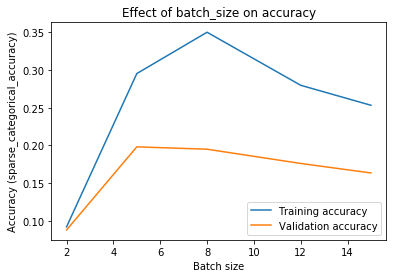

In [39]:
# model_4:
# Fine tunning another hyper-model of model_4; batch_size or learning rate can be tunned. 
# Here, we go for the batch_size:
n_f=600 
n_batch_sizes=[2, 5, 8, 12, 15] # different number of batch_size
accuracy_list=[]
val_accuracy_list=[]

print('Fine tunning another hyper-parameter of model_4:')
for n_b_s in n_batch_sizes:
    accuracy=[]
    val_accuracy=[]
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, 700)
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n_f], df_sample['target_tag'])
        
        reg_coef_4=0.01 # impact coefficient of regularization
        model_4=ks.models.Sequential()
        model_4.add(ks.layers.Dense(units=400, activation=ks.activations. relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=300, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=150, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=150, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_4)))
        model_4.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))

        model_4.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_4.fit(X_train, Y_train, validation_split=0.1, epochs=15, batch_size=n_b_s, verbose=0)
        accuracy.append( np.mean( np.sort(history.history['sparse_categorical_accuracy'])[-3:] ) )
        val_accuracy.append( np.mean( np.sort(history.history['val_sparse_categorical_accuracy'])[-3:] ) )

    accuracy_list.append(np.mean( accuracy ))
    val_accuracy_list.append(np.mean( val_accuracy ))
    print(f'Batch_size = {n_b_s} : done')
    
print(f'\nBest Batch_size: {n_batch_sizes[ np.argmax(val_accuracy_list) ]}')
plt.plot(n_batch_sizes, accuracy_list, label='Training accuracy')
plt.plot(n_batch_sizes, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Batch size'), plt.ylabel('Accuracy (sparse_categorical_accuracy)')
plt.title('Effect of batch_size on accuracy')
plt.legend()

===================================================================================================================

### Model 5:
In the fifth model, we are utlizing a NN with 4 hidden layers; 350, 350, 500, 150 nodes for hidden layers. Actually, we are not changing the depth, but increasing the number of nodes. The activation function is relu (it's sigmoid for output layer). The optimizing algorithm is SGD with lr=0.1 and batch_size=15. Also, we have considered regularization to have 0.01 impact coefficient. About loss function and metric, they are sparse_categorical_crossentropy and sparse_categorical_accuracy.

Validation Curve process for model_5:
(Please note that our metric is acuuracy: sparse_categorical_accuracy)
200 features: done
500 features: done
1000 features: done
1500 features: done
1784 features: done

The optimal value for the Complexity (n_f) is: 1000


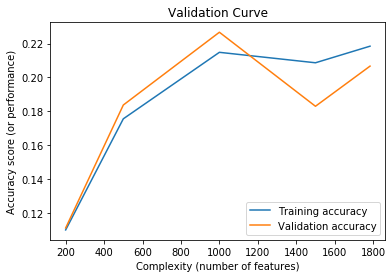

In [41]:
# model_5:
# Let's train some different forms of model_5:
# different number of features; changing the complexity:
n_kept_features=[200, 500, 1000, 1500, df.shape[1]-3]
accuracy_list=[]
val_accuracy_list=[]

print('Validation Curve process for model_5:')
print('(Please note that our metric is acuuracy: sparse_categorical_accuracy)')
start_time=time() # time for fitting
for n in n_kept_features:
    acc=[] # calculate the accuracy for a few times
    val_acc=[] # calculate the validation accuracy for a few times
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, 3000) # choose some samples
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n], df_sample['target_tag'])
    
        reg_coef_5=0.01 # impact coefficient of regularization
        model_5=ks.models.Sequential()
        model_5.add(ks.layers.Dense(units=350, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=350, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=500, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=150, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))
        
        model_5.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_5.fit(X_train, Y_train, validation_split=0.1, epochs=7, batch_size=15, verbose=0)
        acc.append( np.mean( np.sort(history.history['sparse_categorical_accuracy'])[-3:] ) )
        val_acc.append( np.mean( np.sort(history.history['val_sparse_categorical_accuracy'])[-3:] ) )
        
    accuracy_list.append(np.mean(acc))
    val_accuracy_list.append(np.mean( val_acc ))
    print(f'{n} features: done')
    
end_time=time()
    
print(f'\nThe optimal value for the Complexity (n_f) is: {n_kept_features[np.argmax(val_accuracy_list)]}')
plt.plot(n_kept_features, accuracy_list, label='Training accuracy')
plt.plot(n_kept_features, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Complexity (number of features)'), plt.ylabel('Accuracy score (or performance)')
plt.title('Validation Curve')
plt.legend()

In [42]:
# model_5:
# average fitting time (for various n_kept_features):
fit_time_list.append( (end_time-start_time)/len(n_kept_features) ) 
best_accuracy_list.append(max(accuracy_list))
best_val_accuracy_list.append(max(val_accuracy_list))

print('Confusion Matrix for model_5:')
# Please note that there are 27 classes; so it's quiet fair to have a large confusion matrix
start_time=time()
c_m=confusion_matrix_func(model_5, X_test, Y_test)
end_time=time()
predict_time_list.append(end_time-start_time)

c_m

Confusion Matrix for model_5:


,,animal,architecture,art,biology,bodybuilding,business,covid,culture,election,...,marketing,medical,pet,pharmacy,physics,political,science,solar,technology,travel
0,animal,0,0,0,0,0,0,2,0,0,...,2,3,13,0,0,0,0,0,0,0
1,architecture,0,0,3,0,0,0,0,0,0,...,14,13,1,0,0,0,0,0,0,1
2,art,0,0,13,0,0,0,0,0,0,...,10,2,1,0,0,0,0,0,0,1
3,biology,0,0,0,0,0,0,0,0,0,...,3,0,0,0,32,0,0,0,0,0
4,bodybuilding,0,0,0,0,0,0,0,0,0,...,0,3,2,0,0,0,0,0,0,0
5,business,0,0,0,0,0,0,0,0,0,...,9,6,0,0,2,0,0,0,0,0
6,covid,0,0,1,0,0,0,3,0,0,...,13,11,1,0,1,0,0,0,0,2
7,culture,0,0,1,0,0,0,0,0,0,...,9,10,1,0,0,0,0,0,0,0
8,election,0,0,0,0,0,0,0,0,0,...,4,6,0,0,0,0,0,0,0,0
9,engineering,0,0,0,0,0,0,0,0,0,...,10,5,0,0,1,0,0,0,0,0


Learning Curve process for model_5:
700 samples: done
1200 samples: done
1700 samples: done
2200 samples: done
2700 samples: done

Bias: 2.908160348733266
Variance: 0.05389159917831432
According to the amount of bias and variance, it seems that we have enough 
data. Please note that we have 100,000 samples (in total)


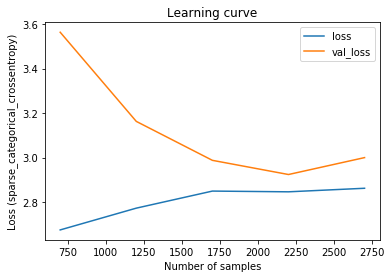

In [43]:
# model_5:
# Now, we are exploring the Learning Curve process:
n_f=600 # let's set the number of features to be 600 for here (we are still in model_5):
n_samples=[700, 1200, 1700, 2200, 2700] # number of data samples we are using here
loss_list=[]
val_loss_list=[]

print('Learning Curve process for model_5:')
for n_s in n_samples:
    loss=[]
    val_loss=[]
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, n_s)
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n_f], df_sample['target_tag'])
        
        reg_coef_5=0.01 # impact coefficient of regularization
        model_5=ks.models.Sequential()
        model_5.add(ks.layers.Dense(units=350, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=350, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=500, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=150, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))
        
        model_5.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_5.fit(X_train, Y_train, validation_split=0.1, epochs=15, batch_size=5, verbose=0)
        loss.append( np.mean( np.sort(history.history['loss'])[:3] ) )
        val_loss.append( np.mean( np.sort(history.history['val_loss'])[:3] ) )

    loss_list.append(np.mean( loss ))
    val_loss_list.append(np.mean( val_loss ))
    print(f'{n_s} samples: done')
    
min_loss_list.append(min(loss_list))
min_val_loss_list.append(min(val_loss_list))
    
print(f'\nBias: {np.mean(loss_list[-2:]+val_loss_list[-2:])}')
print(f'Variance: {np.mean(np.array(val_loss_list[-2:])-np.array(loss_list[-2:]))/2}')
print("""According to the amount of bias and variance, it seems that we have enough 
data. Please note that we have 100,000 samples (in total)""")
plt.plot(n_samples, loss_list, label='loss')
plt.plot(n_samples, val_loss_list, label='val_loss')
plt.xlabel('Number of samples'), plt.ylabel('Loss (sparse_categorical_crossentropy)')
plt.title('Learning curve')
plt.legend()

Please note that we are using regularization with 0.01 impact coefficient. Without regularization, we have to deal with overfitting.

In [44]:
bias_list.append( np.mean(loss_list[-2:]+val_loss_list[-2:]) )
variance_list.append( np.mean(np.array(val_loss_list[-2:])-np.array(loss_list[-2:]))/2 )

Fine tunning another hyper-parameter of model_5:
Batch_size = 2 : done
Batch_size = 5 : done
Batch_size = 8 : done
Batch_size = 12 : done
Batch_size = 15 : done

Best Batch_size: 2


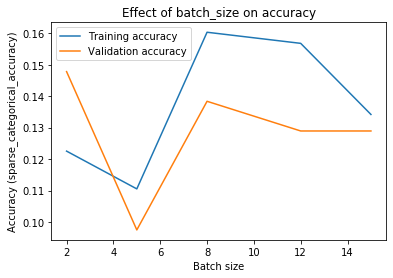

In [46]:
# model_5:
# Fine tunning another hyper-model of model_5; batch_size or learning rate can be tunned. 
# Here, we go for the batch_size:
n_f=600 
n_batch_sizes=[2, 5, 8, 12, 15] # different number of batch_size
# n_batch_sizes=[2,5]
accuracy_list=[]
val_accuracy_list=[]

print('Fine tunning another hyper-parameter of model_5:')
for n_b_s in n_batch_sizes:
    accuracy=[]
    val_accuracy=[]
    for i in range(2): # training a few times, to find the average
        df_sample=sampler(df, 700)
        X_train, X_test, Y_train, Y_test = train_test_split( df_sample.iloc[:,1:n_f], df_sample['target_tag'])
        
        reg_coef_5=0.01 # impact coefficient of regularization
        model_5=ks.models.Sequential()
        model_5.add(ks.layers.Dense(units=350, activation=ks.activations.relu, input_dim=X_train.shape[1], 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=350, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=500, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=150, activation=ks.activations.relu, 
                                    kernel_regularizer=ks.regularizers.l2(reg_coef_5)))
        model_5.add(ks.layers.Dense(units=27, activation=ks.activations.sigmoid))
        
        model_5.compile(optimizer=ks.optimizers.SGD(0.1), loss=ks.losses.sparse_categorical_crossentropy, 
                     metrics=ks.metrics.sparse_categorical_accuracy)
        history=model_5.fit(X_train, Y_train, validation_split=0.1, epochs=5, batch_size=n_b_s, verbose=0)
        accuracy.append( np.mean( np.sort(history.history['sparse_categorical_accuracy'])[-3:] ) )
        val_accuracy.append( np.mean( np.sort(history.history['val_sparse_categorical_accuracy'])[-3:] ) )

    accuracy_list.append(np.mean( accuracy ))
    val_accuracy_list.append(np.mean( val_accuracy ))
    print(f'Batch_size = {n_b_s} : done')
    
print(f'\nBest Batch_size: {n_batch_sizes[ np.argmax(val_accuracy_list) ]}')
plt.plot(n_batch_sizes, accuracy_list, label='Training accuracy')
plt.plot(n_batch_sizes, val_accuracy_list, label='Validation accuracy')
plt.xlabel('Batch size'), plt.ylabel('Accuracy (sparse_categorical_accuracy)')
plt.title('Effect of batch_size on accuracy')
plt.legend()

In [56]:
# For Comparing:
model_list=['model_1', 'model_2', 'model_3', 'model_4', 'model_5']
total_number_of_layers_list=[4, 5, 6, 6, 6]
number_of_hidden_nodes_list=[800, 850, 700, 1000, 1350]
overfit_controling=['Regularization', 'Regularization', 'Dropout', 'Regularization', 'Regularization']
variance_list=np.abs(variance_list)

In [58]:
print('Comparing the models:')
DataFrame(zip(model_list,
          total_number_of_layers_list,
          number_of_hidden_nodes_list,
          fit_time_list,
          predict_time_list,
          best_accuracy_list,
          best_val_accuracy_list,
          min_loss_list,
          min_val_loss_list,
          bias_list,
          variance_list,
          overfit_controling),
          columns=['', 'total_number_of_layers', 'number_of_hidden_nodes', 'fit_time', 'prediction_time',
                   'best_accuracy', 'best_val_accuracy', 'min_loss', 'min_val_loss', 'bias', 'variance',
                   'overfit_controling'])

Comparing the models:


,,total_number_of_layers,number_of_hidden_nodes,fit_time,prediction_time,best_accuracy,best_val_accuracy,min_loss,min_val_loss,bias,variance,overfit_controling
0,model_1,4,800,13.065566,0.294317,0.461180,0.420247,1.545587,2.698786,2.575176,0.203092,Regularization
1,model_2,5,850,43.287993,0.222327,0.416626,0.376296,2.179018,2.981330,2.830942,0.151065,Regularization
2,model_3,6,700,23.715857,0.213158,0.256187,0.392099,2.796139,2.575549,2.778742,0.167064,Dropout
3,model_4,6,1000,30.815356,0.230614,0.226173,0.212593,2.761690,2.933845,2.943768,0.085600,Regularization
4,model_5,6,1350,15.592041,0.240349,0.218436,0.226667,2.675062,2.924040,2.908160,0.053892,Regularization


### Important results:
1. Four or five layers should be enough for our task.
2. We need about 1000 nodes to creat a good model.
3. Regularization is beter than Dropout for this task.
4. It's better to increase the number of nodes at the primary layers, and then decrease them.